<a href="https://colab.research.google.com/github/ownit4137/TIL/blob/main/DL%20from%20Scratch/1/backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation

## 개념

### Affine 계층

- 신경망의 순전파 과정에 수행하는 행렬곱을 기하학에서는 affine transformation이라고 함
- affine변환(행렬 곱)를 수행하는 층을 affine layer이라 함

### ReLU(Rectified Linear Unit)

- activation 함수로 주로 사용됨
- 대표적으로 sigmoid 함수를 사용해왔으나, VGP 발생(가중치가 옅어짐)
- `np.maximum(0, x)`

### 역전파

$Y = X \cdot W + B $ 일때

1. $\frac{\partial L}{\partial W}  = X^T \cdot \frac{\partial L}{\partial Y} $

2. $\frac{\partial L}{\partial B}  = $ sum(axis 0) of $\frac{\partial L}{\partial Y} $

### Softmax with CEE

- 마치막 출력층에서 사용하는 함수
- softmax함수의 손실 함수로 CEE를 사용하면 역전파 식이 깔끔하게 나옴
- 역전파 증명 필요, L -> CEE 역전파 -> softmax 역전파 과정 계산
- 밑딥1 Appendix A

# 코드



In [3]:
from google.colab import drive 
drive.mount('/content/gdrive/')

%cd /content/gdrive/MyDrive/'Colab Notebooks'/

Mounted at /content/gdrive/
/content/gdrive/MyDrive/Colab Notebooks


In [4]:
from dataset.mnist import load_mnist    # 책 코드
from collections import OrderedDict
from PIL import Image
import numpy as np

In [5]:
def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T 

  x = x - np.max(x) # overflow
  return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
        
  # 원핫
  if t.size == y.size:
    t = t.argmax(axis=1)
             
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


# activation func
class Relu:
  def __init__(self):
    self.mask = None

  # x값 중 0보다 작은 값은 0으로
  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx


# affine layer
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    
    self.x = None
    self.original_x_shape = None
    # 가중치와 편향 매개변수의 미분
    self.dW = None
    self.db = None

  def forward(self, x):
    # 텐서 대응
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x

    out = np.dot(self.x, self.W) + self.b
    return out

  # dout을 받아서 각각의 미분값 계산
  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    
    dx = dx.reshape(*self.original_x_shape)  # 텐서 대응
    return dx


# softmax with CEE
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None # 손실함수
    self.y = None    # softmax의 출력
    self.t = None    # 정답 레이블(원-핫 인코딩 형태)
      
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size: # 원핫
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      '''
      t(정답)이 [2, 5, 7, 6, 3, ...] 이면
      dx[0, 2]
      dx[1, 5]
      dx[2, 7]
      ...
      dx[i, t] => i번째 데이터의 t번째 index => 정답이 있어야 하는 index
      을 만들어냄

      각각 -1 => 원핫 일때 yi - ti를 하는 것과 동일
      '''
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size
    
    return dx

In [13]:
class backprop_2layer:
  def __init__(self, input_size, hidden_size, output_size):
    self.init_div = 0.01
    self.params = {}
    self.params['w1'] = self.init_div * np.random.randn(input_size, hidden_size)
    self.params['w2'] = self.init_div * np.random.randn(hidden_size, output_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['b2'] = np.zeros(output_size)

    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
    self.layers['relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
    self.lastLayer = SoftmaxWithLoss()

  def predict(self, x):
    # 층별로 forward
    for layer in self.layers.values():
      x = layer.forward(x)
    
    return x

  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1:   # one-hot일때
      t = np.argmax(t, axis=1)
    
    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def gradient(self, x, t):
    self.loss(x, t)

    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()

    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    grads['w1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].db
    grads['w2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db

    return grads

In [14]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
#x_train = x_train[:1000][:]
#t_train = t_train[:1000][:]

net = backprop_2layer(input_size=784, hidden_size=50, output_size=10)

iter_total = 10000
train_size = x_train.shape[0]
batch_size = 50
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_count = max(train_size / batch_size, 1)

for i in range(iter_total):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  grad = net.gradient(x_batch, t_batch)
  
  for key in('w1', 'b1', 'w2', 'b2'):
    net.params[key] -= learning_rate * grad[key]

  loss = net.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iter_count == 0:
    train_acc = net.accuracy(x_train, t_train)
    test_acc = net.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("iter-", i, " train acc : ", train_acc, " test_acc : ", test_acc)

iter- 0  train acc :  0.1239  test_acc :  0.1223
iter- 1200  train acc :  0.9207666666666666  test_acc :  0.9238
iter- 2400  train acc :  0.9435166666666667  test_acc :  0.9444
iter- 3600  train acc :  0.9538333333333333  test_acc :  0.9538
iter- 4800  train acc :  0.9619  test_acc :  0.9573
iter- 6000  train acc :  0.9678  test_acc :  0.9641
iter- 7200  train acc :  0.9672833333333334  test_acc :  0.9617
iter- 8400  train acc :  0.97505  test_acc :  0.9702
iter- 9600  train acc :  0.9772333333333333  test_acc :  0.9691


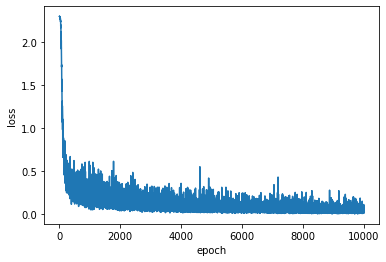

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list)

plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

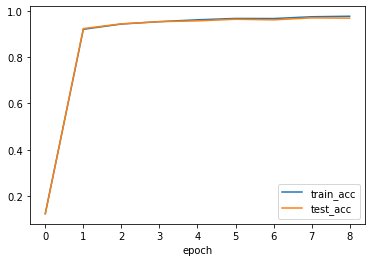

In [20]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)

plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc'])

plt.show()